<a href="https://colab.research.google.com/github/ahsanabbas123/NLP-From-Scratch/blob/master/GeneratingNamesRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): 
  return glob.glob(path)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []

files = findFiles('/content/data/*.txt')

for filename in files:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


# categories: 18 ['Dutch', 'Spanish', 'Vietnamese', 'Italian', 'Russian', 'Japanese', 'French', 'Arabic', 'Chinese', 'English', 'Korean', 'Portuguese', 'German', 'Greek', 'Irish', 'Scottish', 'Czech', 'Polish']
O'Neal


In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module): 

  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.3)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, categoryTensor, inputTensor, hiddenTensor):
    input_combined = torch.cat((categoryTensor, inputTensor, hiddenTensor), 1)
    output = self.i2o(input_combined)
    hidden = self.i2h(input_combined)
    out_combined = torch.cat((hidden, output), 1)
    output = self.o2o(out_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)


In [0]:
# helper functions
import random

# Random item from a list
def randomChoice(Lst):
  return Lst[random.randint(0, len(Lst)-1)]

# Get a random category and random line from that category
def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line

# One-hot vector for category
def categoryTensor(category):
  categoryTensor = torch.zeros(1, n_categories)
  categoryTensor[0][all_categories.index(category)] = 1
  return categoryTensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
  tensor = torch.zeros(len(line),1,n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [0]:
def randomTrainingExample():
  category, line = randomTrainingPair()
  categoryT = categoryTensor(category)
  inputT = inputTensor(line)
  targetT = targetTensor(line)
  return categoryT, inputT, targetT

In [0]:
# training

lr = 0.0005
criterion = nn.NLLLoss()

def train(categoryT, inputT, targetT):
  targetT.unsqueeze_(-1)
  hidden = rnn.initHidden()
  rnn.zero_grad()
  loss = 0

  for i in range(1, inputT.size(0)):
    output, hidden = rnn(categoryT, inputT[i], hidden)
    l = criterion(output, targetT[i])
    loss += l
  
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(-lr, p.grad.data)

  return output, loss.item() / inputT.size(0)

In [0]:
import time
import math

def timeSince(since):

  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s = s - m*60
  return '%d %d' % (m,s)

In [0]:
rnn = RNN(n_letters, 128, n_letters)

iterations = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0
start = time.time() 

for i in range(1, iterations+1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss

  if i % print_every == 0:
    print('%s (%d %d%%) %.4f' % (timeSince(start), i, i / iterations * 100, loss))

  if i % plot_every == 0:
    all_losses.append(total_loss / plot_every)
    total_loss = 0

0 13 (5000 5%) 2.9466
0 27 (10000 10%) 2.7377
0 40 (15000 15%) 3.3041
0 54 (20000 20%) 2.6705
1 7 (25000 25%) 2.4157
1 21 (30000 30%) 3.5045
1 35 (35000 35%) 2.8777
1 48 (40000 40%) 2.3845
2 2 (45000 45%) 2.4122
2 15 (50000 50%) 2.4584
2 29 (55000 55%) 1.9137
2 43 (60000 60%) 2.5201
2 56 (65000 65%) 2.8872
3 10 (70000 70%) 3.0362
3 23 (75000 75%) 2.0668
3 37 (80000 80%) 1.1453
3 51 (85000 85%) 3.5172
4 4 (90000 90%) 1.4670
4 18 (95000 95%) 2.3939
4 31 (100000 100%) 1.9659


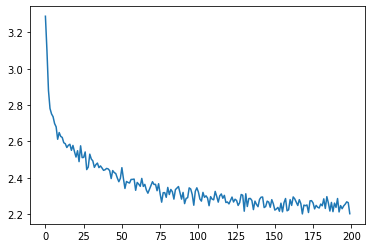

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [0]:
max_length = 20

def sample(category, start_letter = 'A'):

  with torch.no_grad():

    inputT = inputTensor(start_letter)
    categoryT = categoryTensor(category)
    output_name = start_letter
    hidden = rnn.initHidden()
    
    for i in range(max_length):
      output, hidden = rnn(categoryT, inputT[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters-1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      inputT = inputTensor(letter)

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Vietnamese', 'VIE')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Van
Ian
Eann
Ganton
Eare
Rer
Sara
Para
Aamalar
Can
Ho
Ian
